# Inception model - Pasquet

### Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import mse
from scipy.stats import median_abs_deviation

from network_tf2 import *
from function_lib import *

In [2]:
import tensorflow as tf

#Checking for GPU access
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


2023-04-18 01:50:54.173132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 01:50:55.242440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 16655 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
2023-04-18 01:50:55.253363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 16655 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


### Data preparation

In [3]:
img = np.load('data/img_20k.npy')
z = np.load('data/z_20k.npy')

In [4]:
print(img.shape, z.shape)

(20000, 64, 64, 5) (20000,)


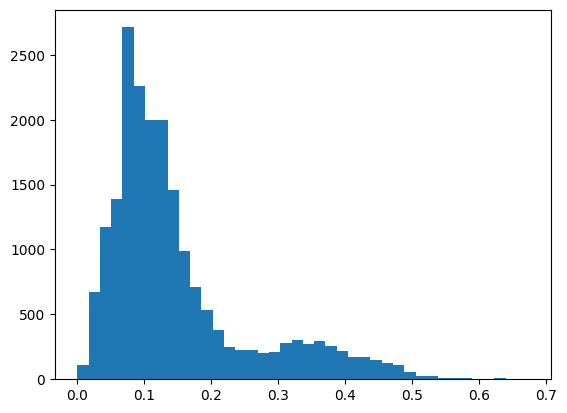

In [5]:
plt.hist(z, bins=40);

In [6]:
# Scaling the images
scaling = []
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    sigma = 1.4826*median_abs_deviation(img[...,i].flatten())
    scaling.append(sigma)

def preprocessing(image):
    return np.arcsinh(img / scaling / 3. )

img = preprocessing(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


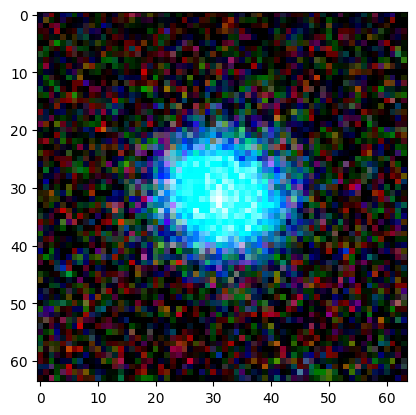

In [7]:
# Check transformed images
plt.imshow(img[0, ..., :3]);

In [244]:
# Split into train and test taking 10,000 samples each
img_train = img[:10000,...]
img_test = img[18000:,...]

z_train = z[:10000]
z_test = z[18000:]

### Model training

In [12]:
model = model_tf2()

2023-04-13 06:39:33.586446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [13]:
#model.summary()

In [14]:
model.compile(optimizer='adam', loss=mse)

In [18]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
tb_callback = tf.keras.callbacks.TensorBoard('./logs/inception', update_freq='batch')


model.fit(x = img_train, 
          y = z_train,
          batch_size = 64,
          validation_data=(img_test, z_test),
          steps_per_epoch=10000//64,
          epochs=50,
          callbacks=[lr_decay, tb_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
156/156 [==============================] - 6s 40ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/50
156/156 [==============================] - 6s 40ms/step - loss: 0.0011 - val_loss: 0.0010 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/50
156/156 [==============================] - 6s 40ms/step - loss: 9.6674e-04 - val_loss: 9.4889e-04 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/50
156/156 [==============================] - 6s 40ms/step - loss: 8.7447e-04 - val_loss: 0.0013 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/50
156/156 [==============================] - 6s 40ms/step - loss: 8.6906e-04 - val_loss: 0.0011 - lr: 6.5610e-04

Epoch 6: Lear

In [19]:
# Get the prediction and plot the results
preds = model.predict(img_test).squeeze()

313/313 [==============================] - 2s 6ms/step


In [20]:
preds

array([0.40532494, 0.3942203 , 0.12537897, ..., 0.20501977, 0.3604164 ,
       0.35617363], dtype=float32)

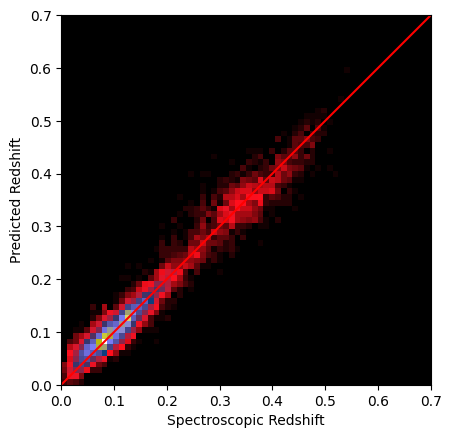

In [21]:
plt.hist2d(z_test, preds, 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');

In [22]:
dz, pred_bias, smad, out_frac = metrics(z_test, preds)
print_metrics(pred_bias, smad, out_frac)

Prediction bias: 0.0031


<IPython.core.display.Latex object>

Outlier fraction: 3.93%


In [23]:
#outliers = [False]*len(z_test)
outliers = np.abs(dz) > 0.05

In [24]:
import scipy.stats
hist = np.histogram(z_test, 50)
prior = scipy.stats.rv_histogram(hist)
hist_out = np.histogram(z_test[outliers], 50)
p_and = scipy.stats.rv_histogram(hist_out)

/tmp/ipykernel_106377/1039034571.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(y, p_and.pdf(y)/prior.pdf(y));


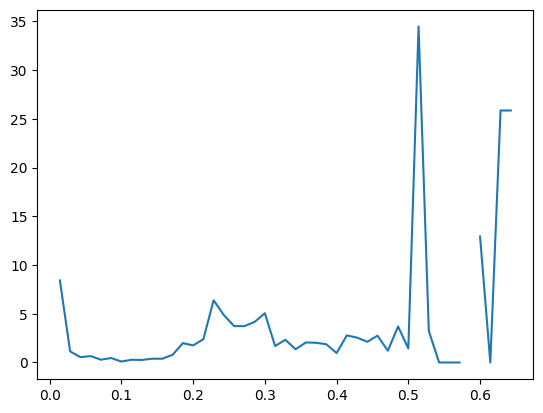

In [25]:
#plt.hist(z_test, bins=50, density=True)
y = np.linspace(0,0.7,50)
plt.plot(y, p_and.pdf(y)/prior.pdf(y));

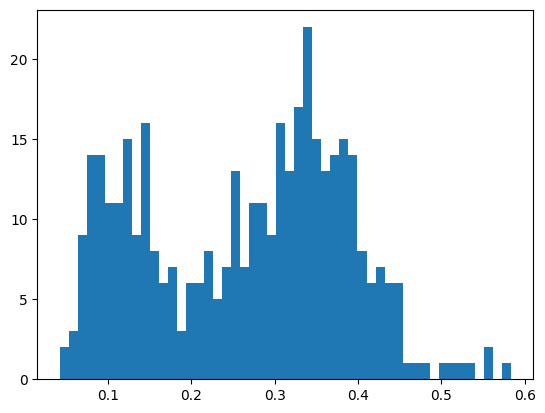

In [26]:
plt.hist(preds[outliers], bins=50);

In [28]:
#plt.hist(z_test[outliers]/prior.pdf(y), bins=50);

### Test on 300 000 images

In [3]:
data = np.load('/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/download')

In [4]:
cat = pd.DataFrame(data["labels"])

In [5]:
cat.shape

(659857, 64)

In [6]:
z = cat.z[:400000]

In [7]:
img = data['cube'][:400000]

In [ ]:
img.shape

In [ ]:
# Scaling the images
from scipy.stats import median_abs_deviation
scaling = []
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    sigma = 1.4826*median_abs_deviation(img[...,i].flatten())
    scaling.append(sigma)

def preprocessing(image):
    return np.arcsinh(img / scaling / 3. )

img = preprocessing(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


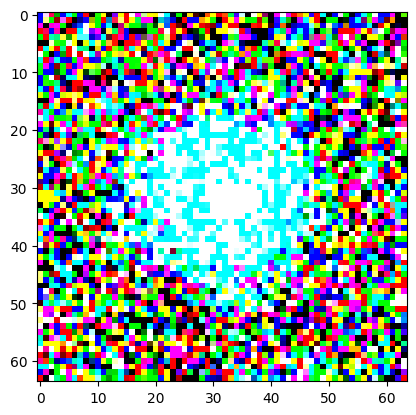

In [38]:
# Check transformed images
plt.imshow(img[0, ..., :3]);

In [ ]:
# Split into train and test taking 10,000 samples each
img_train = img[:300000,...]
img_test = img[300000:,...]

z_train = z[:300000]
z_test = z[300000:]

In [ ]:
model = model_tf2()

In [ ]:
model.compile(optimizer='adam', loss=mse)

In [ ]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
tb_callback = tf.keras.callbacks.TensorBoard('./logs/inception', update_freq='batch')


model.fit(x = img_train, 
          y = z_train,
          batch_size = 64,
          validation_data=(img_test, z_test),
          steps_per_epoch=10000//64,
          epochs=50,
          callbacks=[lr_decay, tb_callback])

In [ ]:
# Get the prediction and plot the results
preds = model.predict(img_test).squeeze()

In [ ]:
plt.hist2d(z_test, preds, 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');

In [ ]:
dz, pred_bias, smad, out_frac = metrics(z_test, preds)
print_metrics(pred_bias, smad, out_frac)

### With Reddening

In [8]:
data = np.load('/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/download')

In [9]:
cat = pd.DataFrame(data["labels"][:20000] )
cat.columns

Index(['imageID', 'specObjID', 'bestObjID', 'class', 'subClass', 'z', 'zErr',
       'objID', 'type', 'flags', 'ra', 'dec', 'l', 'b', 'dered_petro_u',
       'dered_petro_g', 'dered_petro_r', 'dered_petro_i', 'dered_petro_z',
       'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i',
       'petroMagErr_z', 'zphot', 'dzphot', 'zphot_avg', 'zphot_reliable',
       'e_bv_sfd', 'primtarget', 'sectarget', 'targettype', 'spectrotype',
       'Column1', 'v_disp', 'release', 'bptclass', 'lgm_tot_p50',
       'sfr_tot_p50', 'specsfr_tot_p50', 'oh_p50', 'logMass_median',
       'ssfr_mean', 'age_mean', 'tau_mean', 't_age_mean', 'metallicity_mean',
       'dust1_mean', 'dust2_mean', 'EBV', 'fracDev_r', 'deVAB_r', 'deVPhi_r',
       'expAB_r', 'expPhi_r', 'petroR90_r', 'deVRad_r', 'expRad_r',
       'probPSF_r', 'extinction_u', 'extinction_g', 'extinction_r',
       'extinction_i', 'extinction_z'],
      dtype='object')

In [10]:
EBV = cat.EBV
EBV.shape

(20000,)

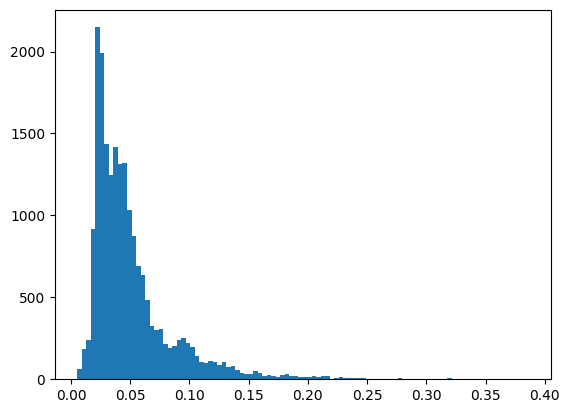

In [11]:
plt.hist(EBV, bins=100);

In [32]:
# Split into train and test taking 10,000 samples each
img_train = img[:10000,...]
img_test = img[10000:,...]

EBV_train = EBV[:10000]
EBV_test = EBV[10000:]

x_train = [img_train, EBV_train]
x_test = [img_test, EBV_test]

z_train = z[:10000]
z_test = z[10000:]

In [33]:
model_ebv = model_tf2(with_ebv=True)

In [34]:
model_ebv.compile(optimizer='adam', loss=mse)

In [35]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
tb_callback = tf.keras.callbacks.TensorBoard('./logs/inception_w_EBV', update_freq='batch')


model_ebv.fit(x = [img_train, EBV_train], 
          y = z_train,
          batch_size = 64,
          validation_data=([img_test, EBV_test], z_test),
          steps_per_epoch=10000//64,
          epochs=50,
          callbacks=[lr_decay, tb_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
156/156 [==============================] - 10s 49ms/step - loss: 0.7060 - val_loss: 0.0017 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/50
156/156 [==============================] - 6s 41ms/step - loss: 0.0016 - val_loss: 0.0016 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/50
156/156 [==============================] - 6s 41ms/step - loss: 0.0014 - val_loss: 0.0014 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/50
156/156 [==============================] - 6s 41ms/step - loss: 0.0013 - val_loss: 0.0015 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/50
156/156 [==============================] - 6s 41ms/step - loss: 0.0010 - val_loss: 0.0013 - lr: 6.5610e-04

Epoch 6: LearningRateSchedul

In [36]:
# Get the prediction and plot the results
preds_ebv = model_ebv.predict([img_test, EBV_test]).squeeze()

313/313 [==============================] - 2s 6ms/step


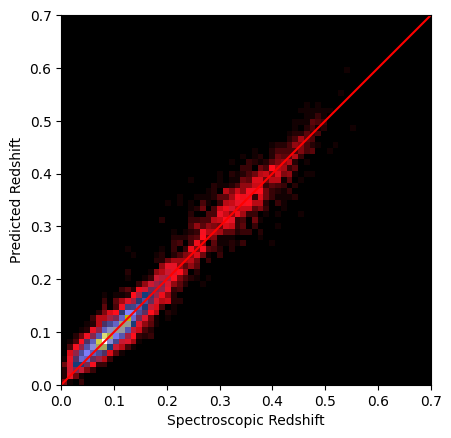

In [37]:
plt.hist2d(z_test, preds, 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');

In [38]:
dz, pred_bias, smad, out_frac = metrics(z_test, preds)
print_metrics(pred_bias, smad, out_frac)

Prediction bias: 0.0027


<IPython.core.display.Latex object>

Outlier fraction: 3.55%


### With distribitions output 

In [336]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [368]:
def model_tf2(with_ebv = False, output_distrib=False, num_components=16):
    
    Image = Input(shape=(64, 64, 5))
    if with_ebv:
        reddening = Input(shape=(1))
    
    conv0 = Conv2D(filters=64, kernel_size=5, padding='same')(Image)
    prelu0 = PReLU()(conv0)
    pool0 = AveragePooling2D(pool_size=2, strides=2, padding='same')(prelu0)
    
    i0 = inception(pool0, 48, 64, name="I0_", output_name="INCEPTION0")
    
    i1 = inception(i0, 64, 92, name="I1_", output_name="INCEPTION1")
    pool1 =AveragePooling2D(pool_size=2, strides=2, padding='same')(i1)
    
    i2 = inception(pool1, 92, 128, name="I2_", output_name="INCEPTION2")
    
    i3 = inception(i2, 92, 128, name="I3_", output_name="INCEPTION3")
    pool2 =AveragePooling2D(pool_size=2, strides=2, padding='same')(i3)
    
    i4 = inception(pool2, 92,128, name="I4_", output_name="INCEPTION4", without_kernel_5=True)
    
    flatten = Flatten()(i4)
    if with_ebv:
        concat = Concatenate()([flatten, reddening])
        d0 = Dense(1024, activation='relu')(concat)
    else:
        d0 = Dense(1024, activation='relu')(flatten)
    d1 = Dense(1024, activation='relu')(d0)
    
    
    
    if not output_distrib:
        outputs = Dense(1)(d1)
    else:
        '''
        categorical_logits = Dense(num_components)(d1)
        alpha = 1 +  Dense(num_components, activation='softplus')(d1)
        beta = 1 + Dense(num_components, activation='softplus')(d1)
        concat = Concatenate()([categorical_logits, alpha, beta])
        
        outputs = tfp.distributions.Independent(tfp.distributions.MixtureSameFamily(
            mixture_distribution=tfp.distributions.Categorical(logits=concat[..., :num_components]),
            components_distribution=tfp.distributions.Beta(concat[..., num_components:2*num_components], concat[..., 2*num_components:])))(concat)
        '''
        param = Dense(3*num_components)(d1)
   
        out = tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(logits=tf.expand_dims(t[..., :num_components], -2)),
                components_distribution=tfd.Beta(
                    1 + tf.nn.softplus(tf.expand_dims(t[..., num_components:2*num_components], -2)),
                    1 + tf.nn.softplus(tf.expand_dims(t[..., 2*num_components:],-2)))), 1))(param)
    
    if with_ebv:
        model = Model(inputs=[Image, reddening], outputs=outputs, name="incept_model")
    else:
        model = Model(inputs=Image, outputs=out, name="incept_model")
        
    return model


In [369]:
model = model_tf2(output_distrib=True)

In [370]:
#model.summary()

In [371]:
negloglik = lambda y, p_y: -p_y.log_prob(y)
model.compile(optimizer='adam', loss=negloglik)

In [372]:
# Beware: differences between model.predict() and model()

yhat = model(np.reshape(img_test[0], (1, 64, 64, 5)))
assert isinstance(yhat, tfd.Distribution)

yhat_ = model.predict(np.reshape(img_test[0], (1, 64, 64, 5)))
assert isinstance(yhat_, np.ndarray)

1/1 [==============================] - 1s 547ms/step


In [373]:
yhat.mean(), yhat.sample()

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4988909]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.54207516]], dtype=float32)>)

In [374]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
#tb_callback = tf.keras.callbacks.TensorBoard('./logs/inception', update_freq='batch')


model.fit(x = img_train,
          y = z_train,
          batch_size = 32,
          validation_data=(img_test, z_test),
          steps_per_epoch=10000//32,
          epochs=10)
          #callbacks=[lr_decay, tb_callback])

Epoch 1/10
312/312 [==============================] - 9s 21ms/step - loss: -1.6230 - val_loss: -1.8335
Epoch 2/10
312/312 [==============================] - 6s 19ms/step - loss: -1.8662 - val_loss: -1.6594
Epoch 3/10
312/312 [==============================] - 6s 19ms/step - loss: -1.9475 - val_loss: -1.7704
Epoch 4/10
312/312 [==============================] - 6s 19ms/step - loss: -2.0425 - val_loss: -1.9606
Epoch 5/10
312/312 [==============================] - 6s 19ms/step - loss: -2.1096 - val_loss: -2.0754
Epoch 6/10
312/312 [==============================] - 6s 19ms/step - loss: -2.1579 - val_loss: -1.9895
Epoch 7/10
312/312 [==============================] - 6s 19ms/step - loss: -2.2110 - val_loss: -2.0846
Epoch 8/10
312/312 [==============================] - 6s 19ms/step - loss: -2.2321 - val_loss: -2.1349
Epoch 9/10
312/312 [==============================] - 6s 19ms/step - loss: -2.2705 - val_loss: -2.1091
Epoch 10/10
312/312 [==============================] - 6s 19ms/step - los

In [375]:
# Get the prediction
#preds = model.predict(img_test).squeeze()

#preds = model(np.reshape(img_test[:50], (50, 64, 64, 5)))
preds = model(img_test)

In [376]:
preds.shape

TensorShape([2000, 1])

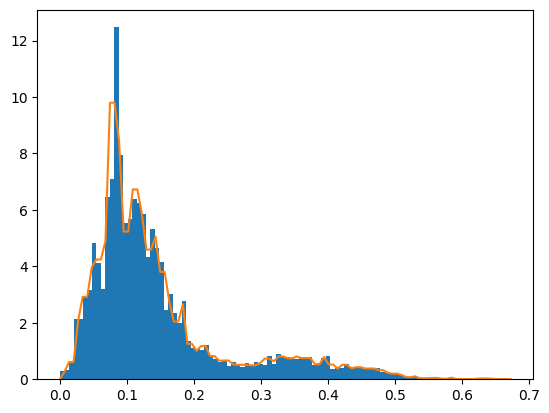

In [377]:
# Calculate the prior

import scipy.stats
hist = np.histogram(z_train, 64)
prior = scipy.stats.rv_histogram(hist)


plt.hist(z_train, 100, density=True);
x = np.linspace(0, z_train.max(), 100)
plt.plot(x, prior.pdf(x));

In [378]:
# This returns the distribution q(z | x) for all clusters
z = np.linspace(0,0.8,100)
logps = []
for i in range(len(z)):
    logps.append(preds.log_prob(z[i]).numpy())
logps = np.stack(logps)

In [379]:
logps.shape

(100, 2000)

/tmp/ipykernel_196835/3667195658.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(z, np.exp(logps[:,i])/prior.pdf(z), label='posterior under flat prior')
/tmp/ipykernel_196835/3667195658.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(z, np.exp(logps[:,i])/prior.pdf(z), label='posterior under flat prior')


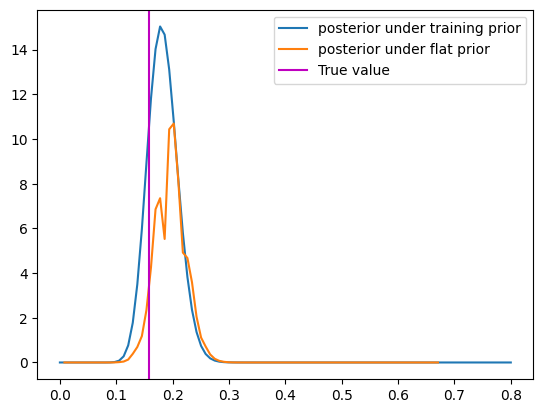

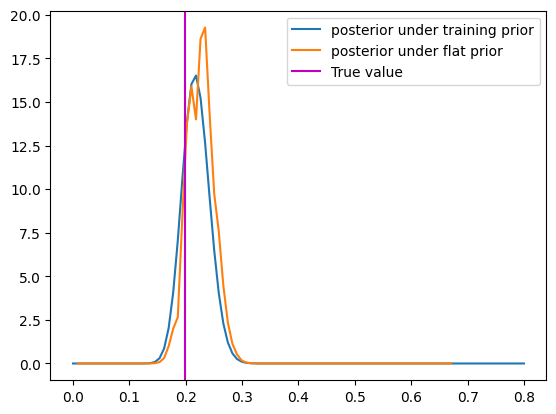

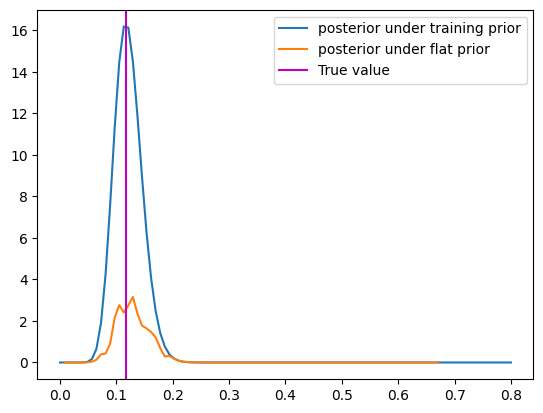

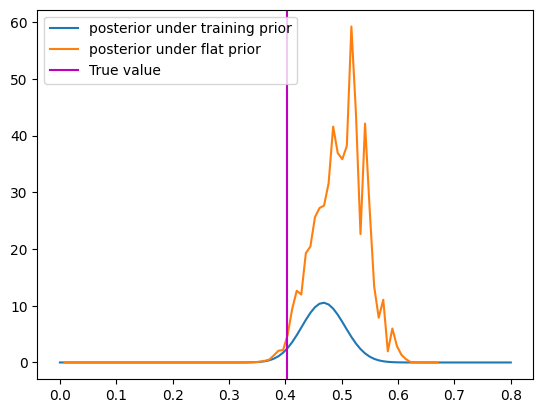

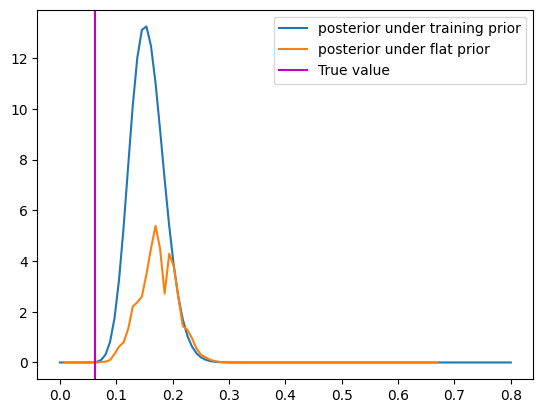

In [380]:
for i in range(5):
    plt.figure()
    plt.plot(z, np.exp(logps[:,i]), label='posterior under training prior')
    plt.plot(z, np.exp(logps[:,i])/prior.pdf(z), label='posterior under flat prior')
    plt.axvline(z_test[i], color='m', label='True value')
    plt.legend()

#### Mean 

In [381]:
# With training prior
point_preds = np.squeeze(preds.mean())

Prediction bias: 0.0076


<IPython.core.display.Latex object>

Outlier fraction: 7.00%


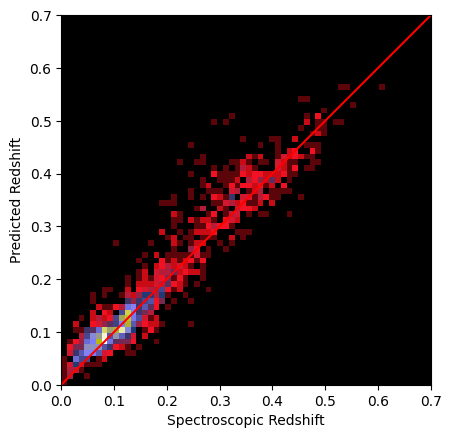

In [382]:
plt.hist2d(z_test, point_preds, 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');
dz, pred_bias, smad, out_frac = metrics(z_test, point_preds)
print_metrics(pred_bias, smad, out_frac)

#### Mode 

In [383]:
# With training prior
z_pred_mode = z[np.exp(logps).argmax(axis=0)]

Prediction bias: 0.0076


<IPython.core.display.Latex object>

Outlier fraction: 7.00%


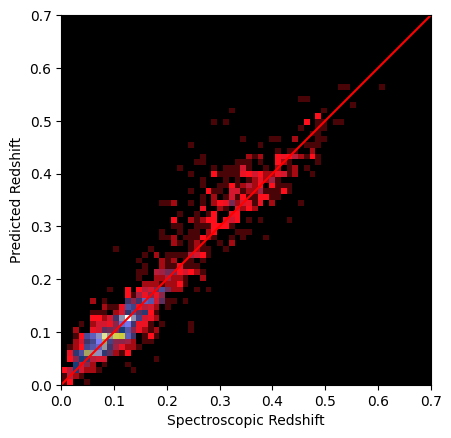

In [384]:
plt.hist2d(z_test, z_pred_mode, 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');
dz, pred_bias, smad, out_frac = metrics(z_test, point_preds)
print_metrics(pred_bias, smad, out_frac)

In [ ]:
from scipy.integrate import simps
y_pred_post_mean = simps(z*corrected_posterior, z,axis=0)/simps(corrected_posterior,z,axis=0)
dz, pred_bias, smad, out_frac_1, out_frac_2 = metrics(Y_true, y_pred_post_mean)
print_metrics(pred_bias, smad, out_frac_1)

NameError: name 'corrected_posterior' is not defined